In [14]:
import matplotlib.pyplot as plt
import numpy as np

## Ballistic annihilation

We are first describing trajectories in a purely mechanical way, as a set of positions function of time $x_i(t)$. Each particle has an uniform velocity $v$, which we randomly draw from the set $\{-v_0, 0, v_0\}$, and the particles positions are bound within a periodic boundary of size $L$. When two particles meet, they will either scatter off each other elastically (if they are of the same kind) or annihilate each other.

A simulation set is described with the class `Ballistic`, whose constructor takes a number of particles, an initial concentration, a box size, and a number of steps of the simulation. Particles are then placed evenly along the axis and given random velocities and random particle/anti-particle states. After that, the `compute()` method is called, which runs the simulation proper, comprised of the following steps:

1. Bounds checking: particles that have not been annihilated are bounds-checked and put back in the $[0, L]$ interval if they are outside it.
2. Collision checking: the distance between pairs of particles is computed at the given time step and the following one; if the sign of the distance has changed, the particles must have crossed paths, which means that they have collided. If the particles are of the same kind, they bounce off each other and their velocities are simply reversed; if they are of opposite kind, the two disappear.
3. All remaining particles are moved by `v*dt`, time advances one step and the loop repeats.

In [15]:
class Ballistic:
    def __init__(self, n, c, L = 1, N = 100):
        self.n = n # number of particles
        self.c = c # initial proportion of particles

        self.N = N # number of time steps
        self.dt = 1/500 # time step interval

        self.L = L # box size
        v0 = 1 # particles initial velocity

        # Place particles at even intervals along the axis and
        # fill the rest with NaNs to avoid plotting values that
        # haven't been calculated
        self.x = np.ma.zeros((self.N, n))
        self.x[0] = self.L*np.linspace(0.02, 0.98, n)
        self.x[1:, :] = np.nan

        # Randomly assign a number of particle and anti-particle
        # states, according to the initial concentration
        n_p = int(n*(1 - c))
        n_a = n - n_p
        self.particles = np.concatenate((-1*np.ones(n_p), np.ones(n_a)))
        np.random.shuffle(self.particles)

        # Give random initial velocities to the particles:
        # either -v0, 0 or v0.
        self.v = np.array(
            [-v0 if v <= v0*1/3
            else 0 if v <= v0*2/3
            else v0 
            for v in v0*np.random.rand(n)])

        self.compute()

    def compute(self):
        n, L, N = self.n, self.L, self.N
        x, v, particles, dt = self.x, self.v, self.particles, self.dt

        self.annihilated = annihilated = np.zeros(n)
        self.wrapped = np.zeros((N, n))

        for ((t, i), _) in np.ndenumerate(x[0:99]):
            # If the particle has already been annihilated,
            # skip to the next one
            if (annihilated[i] == 1):
                continue

            # Bounds checking: wrap particles around [0, L]
            if x[t, i] > L or x[t, i] < 0:
                x[t, i] %= L
                self.wrapped[t, i] = 1

            # Collision checking: if the distance between two
            # particles changes sign between t and t+dt, then
            # they must have collided.
            for j in range(i):
                # Check that the particle hasn't already been
                # annihilated
                if(annihilated[j] == 1):
                    continue

                dx0 = x[t, i] - x[t, j]
                dx1 = x[t+1, i] - x[t+1, j]

                # If one is a particle and the other is an
                # anti-particle, then they annihilate each
                # other; else, they bounce off each other in an
                # elastic fashion.
                if abs(dx0) < 0.1 and dx0*dx1 < 0:
                    if particles[i] == -particles[j]:
                        # NaN values are not shown by
                        # matplotlib, so a particle and
                        # anti-particle tracks stop after their
                        # collision
                        x[t, i] = x[t, j] = np.nan
                        annihilated[i] = annihilated[j] = 1
                    else:
                        # Boucing off elastically means that
                        # velocities are reversed for both
                        # particles
                        v[i] *= -1; v[j] *= -1

            # Move all particles by one step
            x[t + 1] = x[t] + v*dt

    def plot(self):
        N, L = self.N, self.L

        # Avoid plotting lines between wrapped values
        x = np.ma.array(self.x, mask=self.wrapped)

        # Plot the trajectories of all particles
        for i, p in enumerate(self.particles):
            plt.plot(range(N), x[:, i], color = 'b' if p == 1 else 'r')

        plt.xlim(-N/20, N + N/20)
        plt.ylim(-L/10, L + L/10)
        plt.show()

    def concentration(self):
        N, x = self.N, self.x

        # Indices of the particles
        p_idx = np.where(self.particles == 1)[0]

        concentration = np.zeros(N)
        for t in range(N):
            # Particles that have not annihilated
            particles = x[t, p_idx]
            particles = particles[np.where(np.logical_not(np.isnan(particles)))]
            # Particles and anti-particles that have not annihilated
            all = x[t][np.where(np.logical_not(np.isnan(x[t])))]

            concentration[t] = np.size(particles)/np.size(all)

        plt.plot(range(N), concentration)

    def left(self):
        all = self.particles[self.annihilated == 0]
        left_particles = np.size(np.where(all == 1))
        left_all = np.size(all)

        return left_particles/left_all

Once all the calculations are done, the trajectories are plotted as time-position lines, with blue representing particles and red representing anti-particles.

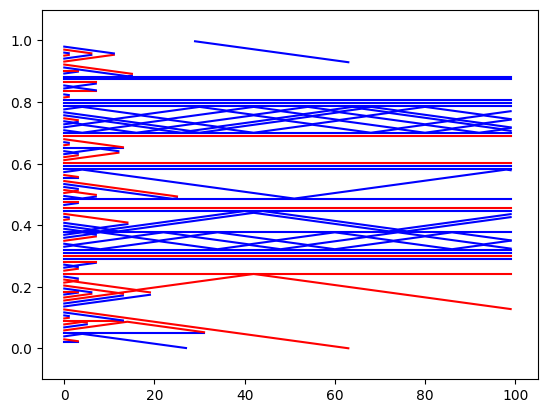

In [16]:
b1 = Ballistic(100, 0.6)
b1.plot()

The concentration of particles at each step of the simulation is then calculated and plotted.

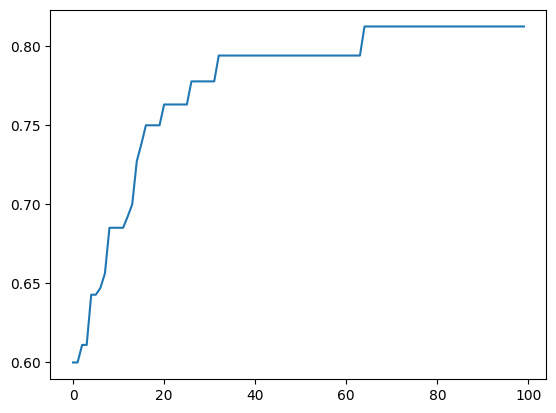

In [17]:
b1.concentration()

In [18]:
n_exp = 25
c1 = 0.6
c2 = 0.4

left_25_c1, left_25_c2 = np.zeros(n_exp), np.zeros(n_exp)
left_50_c1, left_50_c2 = np.zeros(n_exp), np.zeros(n_exp)
left_100_c1, left_100_c2 = np.zeros(n_exp), np.zeros(n_exp)

for i in range(n_exp):
    b1c1 = Ballistic(25, c1)
    b1c2 = Ballistic(25, c2)
    left_25_c1[i] = b1c1.left()
    left_25_c2[i] = b1c2.left()

    b2c1 = Ballistic(50, c1)
    b2c2 = Ballistic(50, c2)
    left_50_c1[i] = b2c1.left()
    left_50_c2[i] = b2c2.left()

    b3c1 = Ballistic(100, c1)
    b3c2 = Ballistic(100, c2)
    left_100_c1[i] = b3c1.left()
    left_100_c2[i] = b3c2.left()

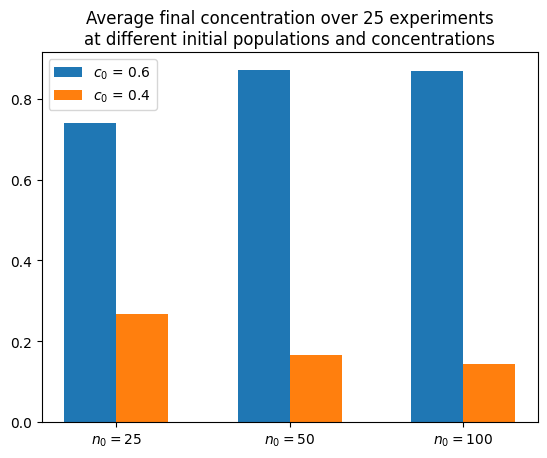

In [20]:
init_pop = [r'$n_0 = 25$', r'$n_0 = 50$', r'$n_0 = 100$']
concentrations = [[np.average(left_25_c1), np.average(left_50_c1), np.average(left_100_c1)],
                  [np.average(left_25_c2), np.average(left_50_c2), np.average(left_100_c2)]]

x = np.arange(len(init_pop))
plt.bar(x, concentrations[0], width=0.3, label=rf'$c_0$ = {c1}')
plt.bar(x + 0.3, concentrations[1], width=0.3, label=rf'$c_0$ = {c2}')
plt.xticks(x + 0.15, init_pop)
plt.title(f'Average final concentration over {n_exp} experiments\nat different initial populations and concentrations')
plt.legend()